In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
import xgboost as xgb

In [6]:
#Info : 552 subjects, 21 waves, 8378 rows
df = pd.read_csv('Speed_Dating_Data.csv', encoding = "ISO-8859-1")
#df = pd.read_csv('SpeedDatingData.csv')

In [157]:
#df.isnull().sum()

In [9]:
#df.head()
#there were 690 matches only out of a potential 4189 matches
matches = pd.crosstab(df['match'], columns = "count")
print(matches)


col_0  count
match       
0       6998
1       1380


In [10]:
data = pd.concat([df.iloc[:,0], #ID
                  df.iloc[:,2], #gender
                  df.iloc[:, 11:17], #partner's id, match, int_corr, samerace, age of partner, race of partner 
                  df.iloc[:,17:23], #stated preferences
                  df.iloc[:,23:24], #decision of partner
                  df.iloc[:,24:32],   # rating by partner for 6 attributes, probability of matching with partner #amb-o has lots of missing values - try eliminating
                  df.iloc[:,32:35], # met, age, field
                  df.iloc[:,39:42],#race, importance of race, importance of religion
                  df.iloc[:,42:43], #from   (DROPPED ZIPCODE AND INCOME AS THEY HAVE TOO MANY MISSING VALUES)
                  df.iloc[:,45:48], #goal, date, go_out
                  df.iloc[:,48:50], #career, career_coded
                  df.iloc[:,50:67], #interests
                  #df.iloc[:,67:69], #exphappy, expnum (DROPPED - TOO MANY MISSING VALUES)
                  df.iloc[:,69:74],  #what subject looks for in the opposite sex - 6 attributes
                  df.iloc[:,74:75],
                  df.iloc[:,81:87], #attr2_1,..
                  df.iloc[:,87:92], #91 is amb3_1
                  df.iloc[:,97:102], #decision, ratings for partner for the 6 attributes
                  #df.iloc[:,102:104], 
                  df.iloc[:,104:107]],axis=1)
                

#data.isnull().sum()
data = data.dropna()
print(np.shape(data))



(6041, 77)


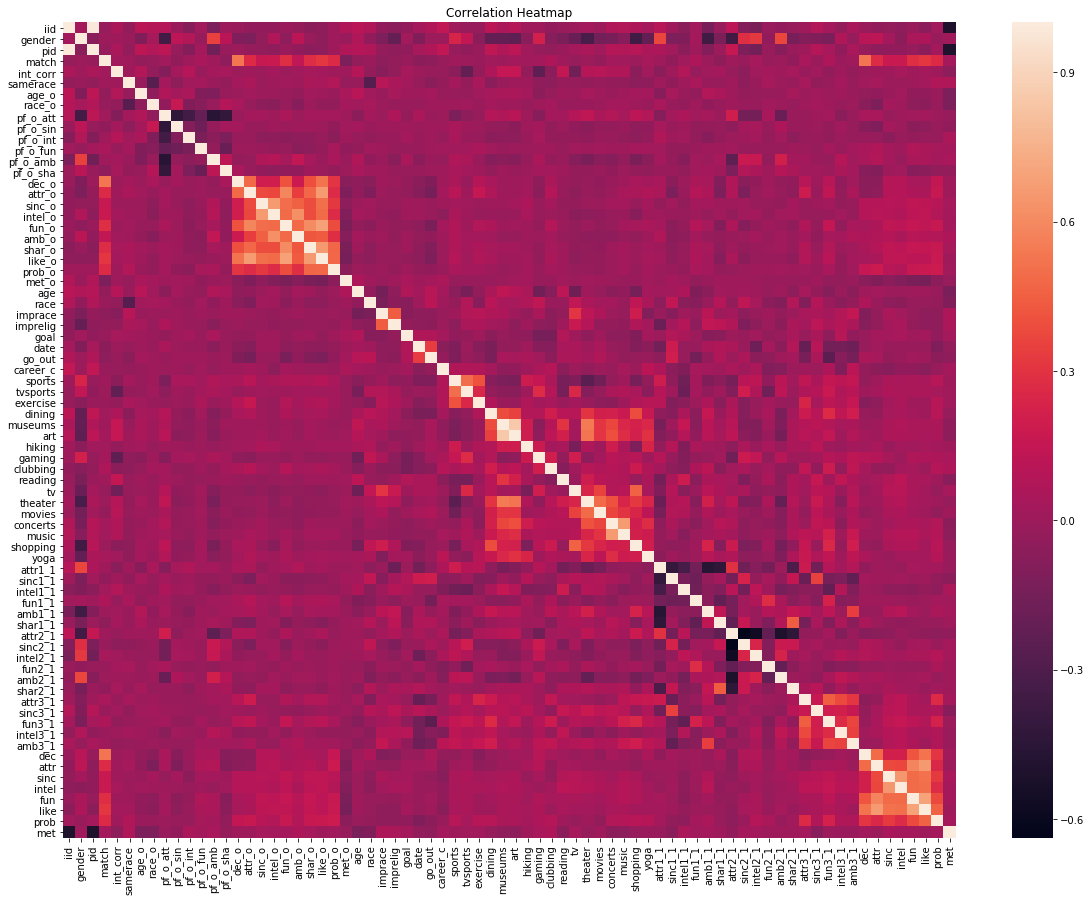

In [11]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)

#From the heatmap, in the match column, we see there's a high positive correlation with these features -
#dec,attr,sinc.. (ratings of partner) and dec_o, attr_o.. (ratings of subject by partner)

In [12]:
data1 = data[['dec', 'dec_o', 'attr', 'attr_o', 'sinc', 'sinc_o', 'intel', 'intel_o' ,'fun', 'fun_o','amb_o', 'like', 'like_o','prob', 'prob_o', 'match']]
corr1 = data1.corr()

print(corr1)

#sns.heatmap(corr1, xticklabels = corr1.columns.values, yticklabels = corr1.columns.values)

              dec     dec_o      attr    attr_o      sinc    sinc_o     intel  \
dec      1.000000 -0.059567  0.488982 -0.066278  0.208105  0.090666  0.207812   
dec_o   -0.059567  1.000000 -0.060715  0.487445  0.094586  0.199644  0.089816   
attr     0.488982 -0.060715  1.000000 -0.045899  0.379249  0.095346  0.371460   
attr_o  -0.066278  0.487445 -0.045899  1.000000  0.097414  0.385818  0.094254   
sinc     0.208105  0.094586  0.379249  0.097414  1.000000  0.099532  0.651428   
sinc_o   0.090666  0.199644  0.095346  0.385818  0.099532  1.000000  0.087266   
intel    0.207812  0.089816  0.371460  0.094254  0.651428  0.087266  1.000000   
intel_o  0.087382  0.203672  0.098067  0.368624  0.087614  0.661394  0.071591   
fun      0.413855  0.043248  0.581734  0.061037  0.489867  0.131349  0.488909   
fun_o    0.039250  0.408875  0.065516  0.586963  0.134933  0.499286  0.120597   
amb_o    0.063585  0.174917  0.070812  0.338273  0.096754  0.453719  0.058773   
like     0.519321  0.036998 

## OLS

In [14]:
X_reg = data[['dec','dec_o','attr','attr_o','fun','fun_o','like','like_o', 'amb_o','int_corr', 'prob', 'prob_o']]
y_reg = data.match
model = sm.OLS(y_reg, X_reg)
result_reg = model.fit()
result_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  match   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     936.5
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:46:36   Log-Likelihood:                -145.55
No. Observations:                6041   AIC:                             315.1
Df Residuals:                    6029   BIC:                             395.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dec            0.4463      0.008     58.397      0.000       0.431       0.461
dec_o          0.4417      0.008     57.114      0.000       0.427       0.457
attr           0.0004      0.002      0.172      0.863      -0.004       0.005
attr_o         0.0011      0.002      0.487      0.626      -0.003       0.006
fun            0.0014      0.002      0.607      0.544      -0.003       0.006
fun_o          0.0066      0.002      2.708      0.007       0.002       0.011
like          -0.0138      0.003     -4.746      0.000      -0.020      -0.008
like_o        -0.0120      0.003     -4.103      0.000      -0.018      -0.006
amb_o         -0.0123      0.002     -6.268      0.000      -0.016      -0.008
int_corr       0.0117      0.010      1.119      0.263      -0.009       0.032
prob          -0.0032      0.002     -1.815      0.070      -0.007       0.000
prob_o        -0.0016      0.002     -0.910      0.363      -0.005       0.002
==============================================================================
Omnibus:                       58.406   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              739.202
Skew:                           0.244   Prob(JB):                    3.05e-161
Kurtosis:                       1.357   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Classification- Kavita

gender
0    4184
1    4194
dtype: int64


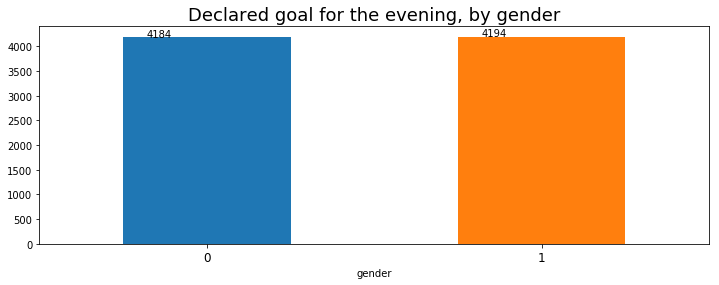

In [231]:
tmp = df[['attr', 'sinc','intel','fun','gender']].groupby(['gender']).size()
print(tmp)
ax = tmp.plot(kind='bar', figsize=(12,4))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation='horizontal')

ax.set_title('Declared goal for the evening, by gender', fontsize=18)

for i in ax.patches:
    ax.text(i.get_x()+.07, i.get_height()+3, \
            str(round((i.get_height()), 1)), fontsize=10)

In [69]:
#columns_drop=['positin1','round','iid','idg','']

In [50]:
#data.iid[df.id==10].count()

480

In [22]:
n=data.isna().sum()
if n.any()>0:
    print(n)
else:
    print('No null values')

No null values


In [23]:
#for col in df.columns:
#    if df[col].isna().sum()>6000:
#        columns_drop.append(col)
#df.drop(columns_drop,axis=1)

In [85]:
class_counts=df["match"].value_counts()
#print(f'data points per class-\n{iris_class_counts}')
x=np.array(range(df.shape[0]))
print(x)
print(class_counts)
#plt.hist(x,class_counts)

[   0    1    2 ... 8375 8376 8377]
0    6998
1    1380
Name: match, dtype: int64


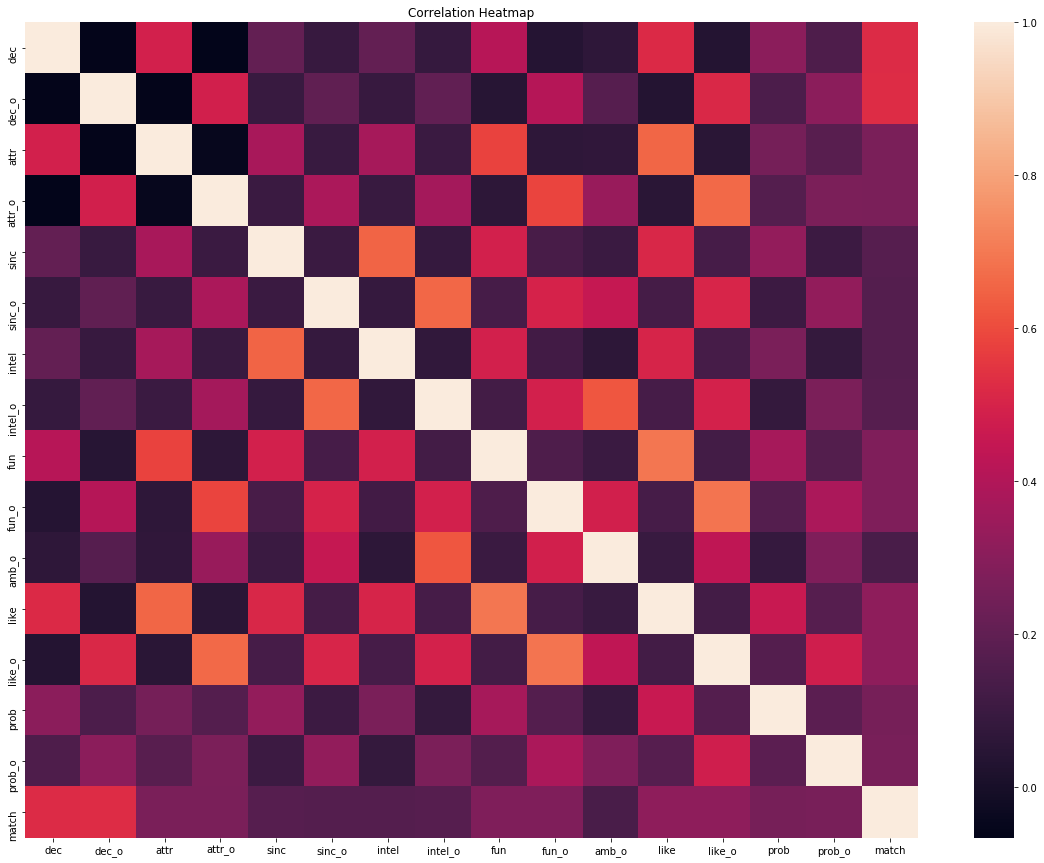

In [25]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Classification using random forest

In [101]:
def RF(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,50]
    count=1
    for dep in depth_values:        
        estim=[5,10,20]
        for n in estim:
            rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep,class_weight = "balanced")
            rf_clf.fit(X_train,y_train)
            y_coef=rf_clf.feature_importances_
            
            y_pred=rf_clf.predict(X_test)
            trauc=rf_clf.predict_proba(X_train)[:,1]
            cvauc=rf_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
            #print(f'{count}. depth={dep},estim={n} cv accuracy={cv_auc}')
    #print(cv_auc)
    return  tr_auc,cv_auc

In [111]:
def plot_heatmap(auc_tr,auc_cv):
    cm_pred=auc_cv
    depth_values=[1,5,10,20,50]
    estim=[5,10,20]
    cm = pd.DataFrame(auc_cv, index =depth_values, columns = estim)
    #auc_hm=cm.pivot()
    plt.figure(figsize = (5,3))
    sns.heatmap(cm, annot=True)

In [134]:
def test_RandomForest(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep, class_weight = "balanced")
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)

#### Features=like,dec

In [195]:
X=data[['like','dec']]
y=data['match']
X_1, X_test_ld, y_1, y_test_ld = train_test_split(X, y, test_size=0.2, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ld, X_cv_ld, y_train_ld, y_cv_ld = train_test_split(X_1, y_1, test_size=0.2)

In [196]:
tr_auc, cv_auc=RF(X_train_ld,y_train_ld,X_cv_ld,y_cv_ld)

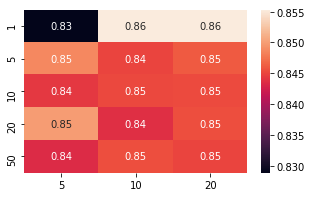

In [197]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
plot_heatmap(tr_auc, cv_auc)

In [204]:
dep=50
n=10

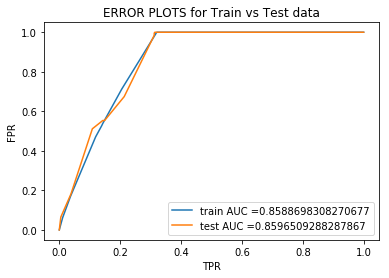

Train confusion matrix
[[2177 1023]
 [   1  664]]
Test confusion matrix
[[684 310]
 [  1 214]]


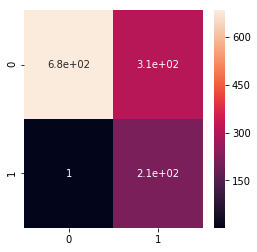

In [205]:
test_RandomForest(X_train_ld,y_train_ld,X_test_ld,y_test_ld,dep,n)

#### Features=like,dec,fun,int_corr

In [210]:
X=data[['like','dec','fun','int_corr']]
y=data['match']
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

In [211]:
tr_auc, cv_auc=RF(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

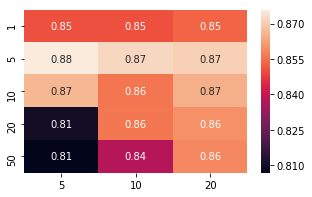

In [212]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
plot_heatmap(tr_auc, cv_auc)

In [213]:
dep=5
n=20

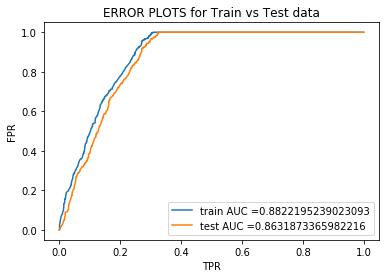

Train confusion matrix
[[1673  769]
 [   0  517]]
Test confusion matrix
[[1011  483]
 [   3  316]]


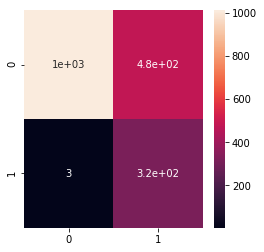

In [214]:
test_RandomForest(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

## XGBoost

In [220]:
def xgb_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,100]
    count=1
    for dep in depth_values:        
        estim=[5, 50, 100]
        for n in estim:
            xgb_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
            xgb_clf.fit(X_train,y_train)
            #y_coef=rf_clf.feature_importances_
            #print(f'{count}. depth={dep},estim={n} running...')
            y_pred=xgb_clf.predict(X_test)
            trauc=xgb_clf.predict_proba(X_train)[:,1]
            cvauc=xgb_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
    #print(cv_auc)
    return  tr_auc,cv_auc

In [215]:
def test_xgb(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)

In [221]:
tr_auc, cv_auc=xgb_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

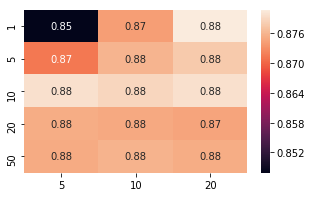

In [222]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
plot_heatmap(tr_auc, cv_auc)

In [227]:
n=10
dep=10

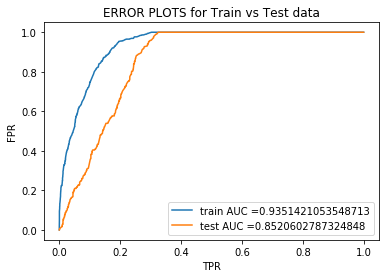

Train confusion matrix
[[2362   80]
 [ 286  231]]
Test confusion matrix
[[1367  127]
 [ 227   92]]


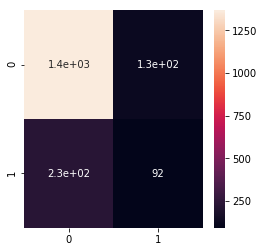

In [228]:
test_xgb(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)